<a href="https://colab.research.google.com/github/lemurchik65/VfhECz15082000/blob/master/mnist_cDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dense, \
                                    Reshape, Conv2DTranspose, Dropout, \
                                    Embedding, Concatenate, Input
from tensorflow.keras.initializers import RandomNormal

from tensorflow.keras.optimizers import Adam

In [0]:
opt=Adam(lr=0.0002, beta_1=0.5)

In [0]:
def create_discriminator(in_shape=(28,28,1), n_classes=10):
    # input layer
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same',
                activation=LeakyReLU(alpha=0.2)
                )(merge)
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same',
                activation=LeakyReLU(alpha=0.2)
                )(fe)
    # Flatten feature maps
    fe = Flatten()(fe)  
    # Regularization via dropout
    fe = Dropout(0.4)(fe)
    # Output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # Creating model
    model = Model([in_image, in_label], out_layer)
    model. compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

    

In [0]:
def create_generator(latent_dim=100, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7*7
    li = Dense(n_nodes)(li)
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128*7*7
    gen = Dense(n_nodes, activation=LeakyReLU(alpha=0.2))(in_lat)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsampling to 14x14
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(3,3),
                          strides=(2,2),
                          padding='same',
                          activation=LeakyReLU(alpha=0.2)
                          )(merge)
    # updampling to 28x28
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(3,3),
                          strides=(2,2),
                          padding='same',
                          activation=LeakyReLU(alpha=0.2)
                          )(gen)
    # output
    out_layer = Conv2D(filters=1,
                       kernel_size=(7,7),
                       activation='tanh',
                       padding='same'
                       )(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model


In [0]:
def create_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # get noise and label inputs from generator
    gen_noise, gen_label = generator.input
    # get image output from the generator model
    gen_output = generator.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = discriminator([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
def load_real_data(dataset):
    # Loading data
    (X_train, y_train), (X_test, y_test) = dataset.load_data()
    # We don't need separate test data so we can add it to our training data
    X_train = np.concatenate((X_train, X_test), axis=0)
    y_train = np.concatenate((y_train, y_test), axis=0)
    # Conv2D awaits 3-dimensional input data (color channel) so, we must add 1 axis
    X_train = np.expand_dims(X_train, axis=-1)
    # Rescale our data from [0, 255] to [-1,1]
    X_train = X_train.astype('float32')
    X_train = (X_train - 127.5) / 127.5
    return [X_train, y_train]

In [0]:
def gen_real_batch(dataset, n_samples):
    X_train, y_train = dataset
    # Generate n random indexes
    ix = np.random.randint(0, X_train.shape[0], n_samples)
    # Select n random images from our imageset
    X = X_train[ix]
    labels = y_train[ix]
    y = np.ones(n_samples)
    return [X, labels], y

In [0]:
# Create n random latent-space vectors
def gen_latent_vecs(n_samples, latent_dim=100, n_classes=10):
    latent_vecs = np.random.normal(0, 1, [n_samples, latent_dim])
    labels = np.random.randint(0, n_classes, n_samples)
    return [latent_vecs, labels]

In [0]:
def gen_fake_batch(generator, n_samples, latent_dim=100, n_classes=10):
    [latent_vecs, labels] = gen_latent_vecs(n_samples, latent_dim, n_classes)
    X = generator.predict([latent_vecs, labels])
    y = np.zeros(n_samples)
    return [X, labels], y

In [0]:
def gen_train_batch(generator, dataset, batch_size, latent_dim=100, n_classes=10):
    half_batch_size = batch_size // 2
    # Get a half batch of real samples
    [X_real, real_labels], y_real = gen_real_batch(dataset, half_batch_size)
    # Get a half batch of fake samples
    [X_fake, fake_labels], y_fake = gen_fake_batch(generator, half_batch_size, \
                                                   latent_dim, n_classes)
    # Make a mixed batch
    X = np.concatenate((X_real, X_fake), axis=0)
    y = np.concatenate((y_real, y_fake), axis=0)
    labels = np.concatenate((real_labels, fake_labels), axis=0)
    # Shuffle real and fake images
    shuffle = np.random.randint(0, batch_size, batch_size)
    X = X[shuffle]
    y = y[shuffle]
    labels = labels[shuffle]
    return [X, labels], y

In [0]:
def print_generated_images(generator, h, w, latent_dim=100):
    n = h*w
    X, _ = gen_latent_vecs(n, latent_dim)
    labels = np.asarray([x for _ in range(h) for x in range(w)])
    y_p = generator.predict([X, labels])

    fig = plt.figure(figsize=(20,10))
    for i in range(n):
        plt.subplot(h, w, 1 + i)
        plt.axis('off')
        plt.title("label: {}".format(labels[i]))
        plt.imshow(y_p[i, :, :, 0], cmap='gray_r')
    plt.show()

In [0]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epoches=100, \
          batch_size=128, n_classes=10):
    X_train, y_train = dataset
    n_batches = X_train.shape[0] // batch_size
    half_batch_size = batch_size // 2

    for i in range(n_epoches):
        for j in range(n_batches):
            # Train discriminator
            [X_d, labels_d], y_d = gen_train_batch(generator, dataset, \
                                                   batch_size, latent_dim)
            d_loss, d_acc = discriminator.train_on_batch([X_d, labels_d], y_d)
            # Train generator
            [X_gan, labels] = gen_latent_vecs(batch_size, latent_dim)
            y_gan = np.ones(batch_size)
            g_loss = gan.train_on_batch([X_gan, labels], y_gan)

            print('\r>%d, %d/%d, d_l=%.3f, d_a=%.3f g=%.3f' % (i+1, j+1, n_batches, d_loss, d_acc, g_loss), end='')
        print()
        if i == 0 or i == 1 or (i+1) % 20 == 0:
            print_generated_images(generator, 4, 10, latent_dim)

In [0]:
latent_dim = 100
discriminator = create_discriminator()
generator = create_generator(latent_dim)
gan_model = create_gan(generator, discriminator)
dataset = load_real_data(mnist)
train(generator, discriminator, gan_model, dataset, latent_dim)
# Save the generator model
gan_model.save('gan.h5')
generator.save('generator.h5')
discriminator.save('discriminator.h5')

>1, 182/546, d_l=0.489, d_a=0.812 g=1.095

KeyboardInterrupt: ignored

>1, 546/546, d_l=0.637, d_a=0.664 g=0.751


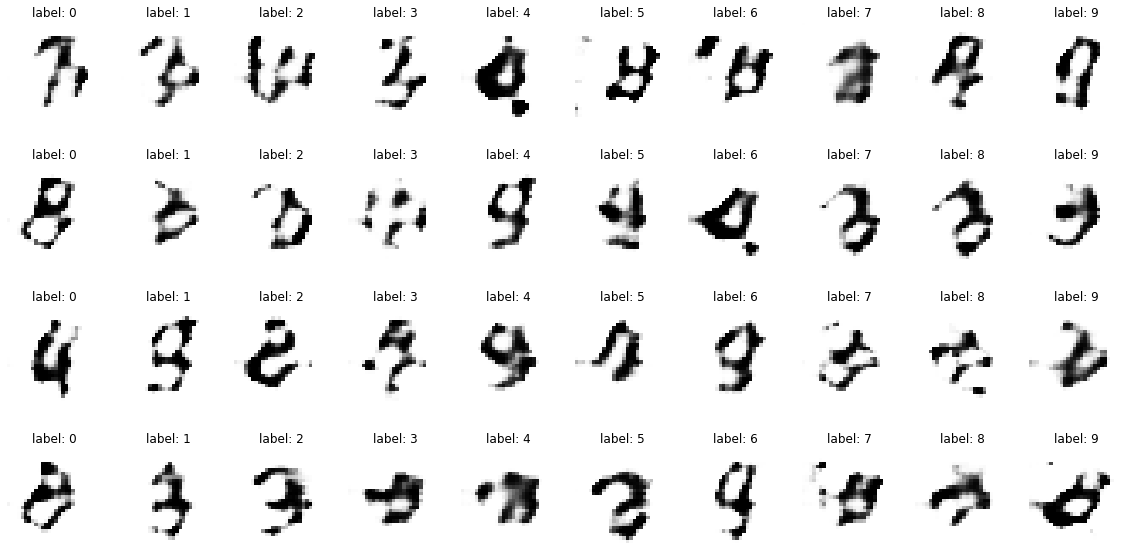

>2, 546/546, d_l=0.690, d_a=0.555 g=0.751


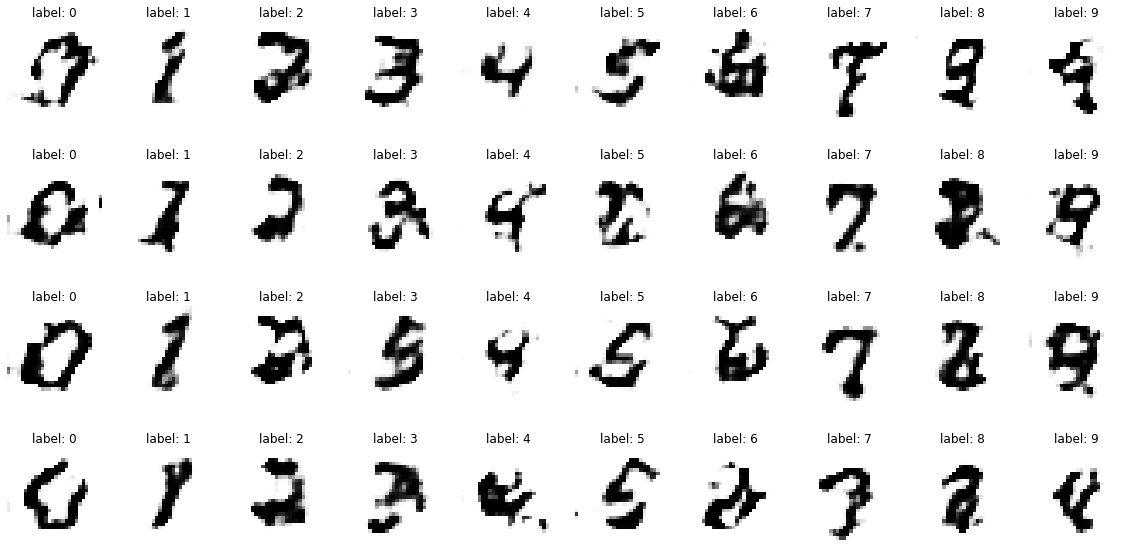

>3, 546/546, d_l=0.599, d_a=0.672 g=0.843
>4, 546/546, d_l=0.614, d_a=0.648 g=0.972
>5, 546/546, d_l=0.640, d_a=0.625 g=0.712
>6, 546/546, d_l=0.604, d_a=0.672 g=0.875
>7, 546/546, d_l=0.617, d_a=0.680 g=0.841
>8, 546/546, d_l=0.598, d_a=0.734 g=0.995
>9, 546/546, d_l=0.566, d_a=0.727 g=1.132
>10, 546/546, d_l=0.589, d_a=0.672 g=0.739
>11, 546/546, d_l=0.538, d_a=0.773 g=1.088
>12, 546/546, d_l=0.605, d_a=0.648 g=0.960
>13, 546/546, d_l=0.564, d_a=0.742 g=0.983
>14, 546/546, d_l=0.582, d_a=0.703 g=1.272
>15, 546/546, d_l=0.612, d_a=0.672 g=0.812
>16, 546/546, d_l=0.540, d_a=0.781 g=0.920
>17, 546/546, d_l=0.582, d_a=0.688 g=0.770
>18, 546/546, d_l=0.611, d_a=0.656 g=0.804
>19, 546/546, d_l=0.597, d_a=0.664 g=0.742
>20, 546/546, d_l=0.593, d_a=0.711 g=0.966


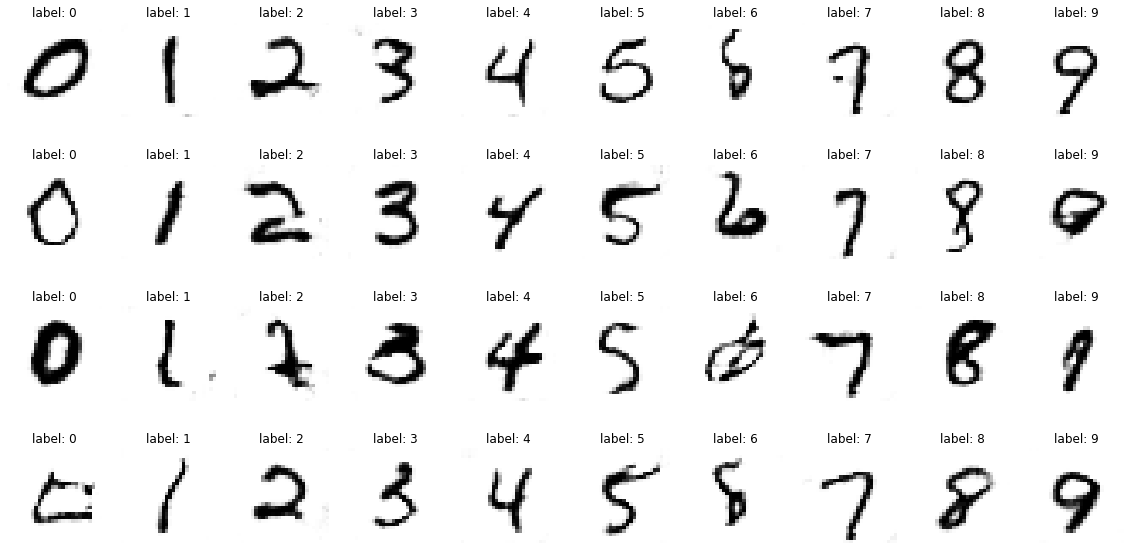

>21, 546/546, d_l=0.610, d_a=0.656 g=1.356
>22, 546/546, d_l=0.603, d_a=0.641 g=1.080
>23, 546/546, d_l=0.518, d_a=0.781 g=1.271
>24, 546/546, d_l=0.619, d_a=0.648 g=0.959
>25, 546/546, d_l=0.614, d_a=0.656 g=0.764
>26, 546/546, d_l=0.680, d_a=0.570 g=1.039
>27, 546/546, d_l=0.592, d_a=0.672 g=1.021
>28, 546/546, d_l=0.539, d_a=0.734 g=0.855
>29, 546/546, d_l=0.615, d_a=0.648 g=0.743
>30, 546/546, d_l=0.574, d_a=0.680 g=1.016
>31, 546/546, d_l=0.627, d_a=0.648 g=0.781
>32, 546/546, d_l=0.655, d_a=0.625 g=1.067
>33, 546/546, d_l=0.550, d_a=0.664 g=0.851
>34, 546/546, d_l=0.584, d_a=0.695 g=0.982
>35, 546/546, d_l=0.591, d_a=0.711 g=1.190
>36, 546/546, d_l=0.564, d_a=0.695 g=0.822
>37, 546/546, d_l=0.673, d_a=0.562 g=1.007
>38, 546/546, d_l=0.683, d_a=0.562 g=1.175
>39, 546/546, d_l=0.704, d_a=0.609 g=0.784
>40, 546/546, d_l=0.642, d_a=0.633 g=1.021


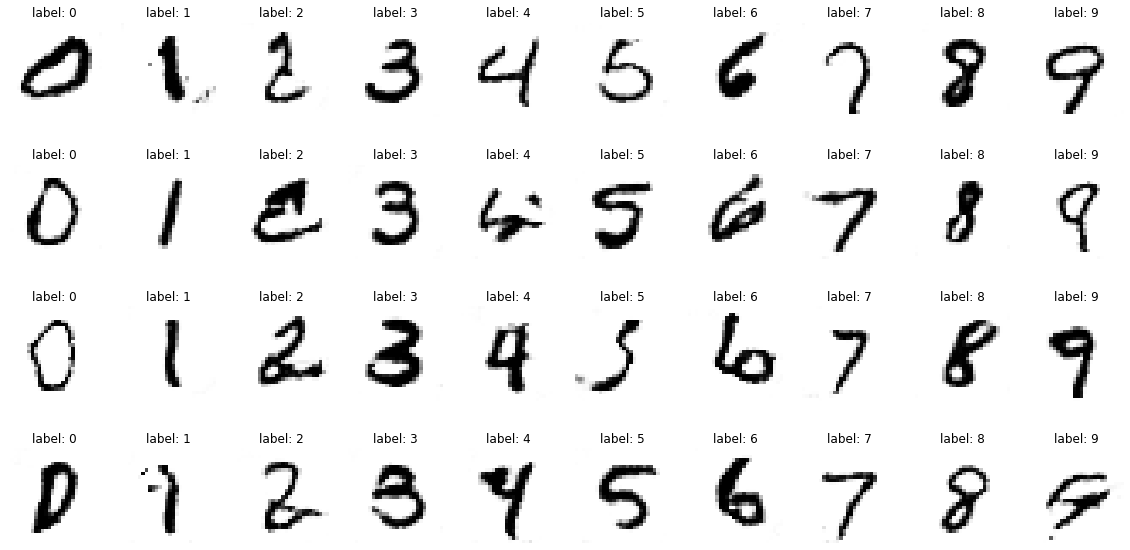

>41, 546/546, d_l=0.704, d_a=0.531 g=1.044
>42, 546/546, d_l=0.620, d_a=0.656 g=0.770
>43, 546/546, d_l=0.606, d_a=0.625 g=0.883
>44, 546/546, d_l=0.638, d_a=0.625 g=0.906
>45, 546/546, d_l=0.597, d_a=0.656 g=0.826
>46, 546/546, d_l=0.601, d_a=0.672 g=0.609
>47, 546/546, d_l=0.604, d_a=0.695 g=1.081
>48, 546/546, d_l=0.624, d_a=0.664 g=0.967
>49, 546/546, d_l=0.637, d_a=0.641 g=0.847
>50, 546/546, d_l=0.669, d_a=0.578 g=0.737
>51, 546/546, d_l=0.617, d_a=0.602 g=1.165
>52, 546/546, d_l=0.604, d_a=0.711 g=0.976
>53, 546/546, d_l=0.568, d_a=0.719 g=0.851
>54, 546/546, d_l=0.609, d_a=0.633 g=0.909
>55, 546/546, d_l=0.544, d_a=0.742 g=1.309
>56, 546/546, d_l=0.645, d_a=0.594 g=1.223
>57, 546/546, d_l=0.605, d_a=0.648 g=0.888
>58, 546/546, d_l=0.580, d_a=0.664 g=1.020
>59, 546/546, d_l=0.584, d_a=0.672 g=0.796
>60, 546/546, d_l=0.514, d_a=0.812 g=1.027


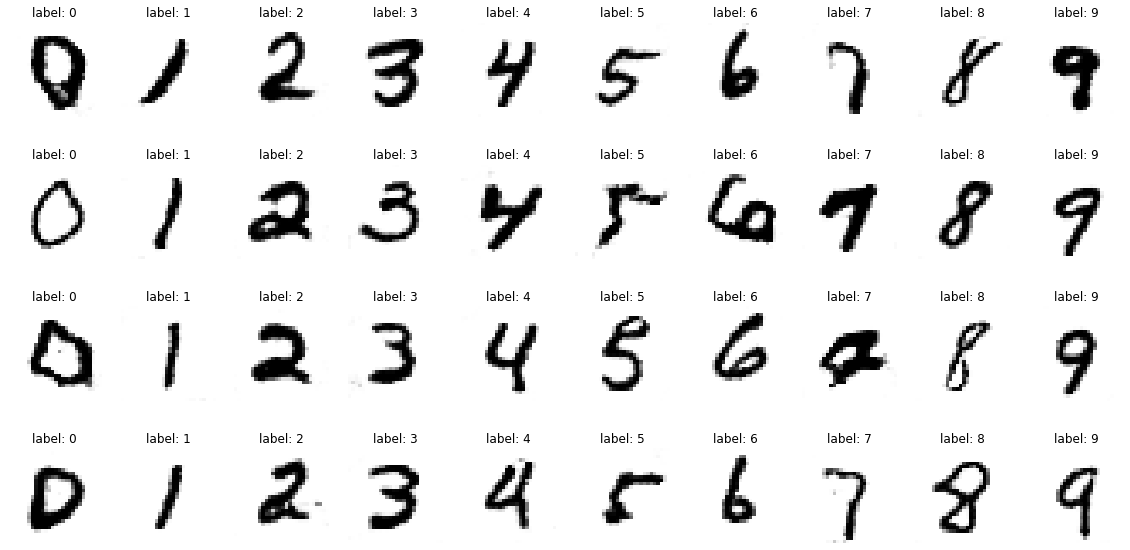

>61, 546/546, d_l=0.604, d_a=0.633 g=0.703
>62, 546/546, d_l=0.559, d_a=0.695 g=1.102
>63, 546/546, d_l=0.596, d_a=0.633 g=0.845
>64, 546/546, d_l=0.657, d_a=0.688 g=0.902
>65, 546/546, d_l=0.665, d_a=0.562 g=1.000
>66, 546/546, d_l=0.630, d_a=0.602 g=0.922
>67, 546/546, d_l=0.650, d_a=0.586 g=0.940
>68, 546/546, d_l=0.562, d_a=0.688 g=0.796
>69, 546/546, d_l=0.601, d_a=0.664 g=0.940
>70, 546/546, d_l=0.628, d_a=0.617 g=0.978
>71, 546/546, d_l=0.572, d_a=0.680 g=0.699
>72, 546/546, d_l=0.584, d_a=0.695 g=0.810
>73, 546/546, d_l=0.621, d_a=0.664 g=0.711
>74, 546/546, d_l=0.642, d_a=0.602 g=0.841
>75, 546/546, d_l=0.633, d_a=0.586 g=0.852
>76, 546/546, d_l=0.630, d_a=0.656 g=0.868
>77, 546/546, d_l=0.598, d_a=0.656 g=1.301
>78, 546/546, d_l=0.573, d_a=0.703 g=0.990
>79, 546/546, d_l=0.573, d_a=0.672 g=0.802
>80, 546/546, d_l=0.584, d_a=0.758 g=0.825


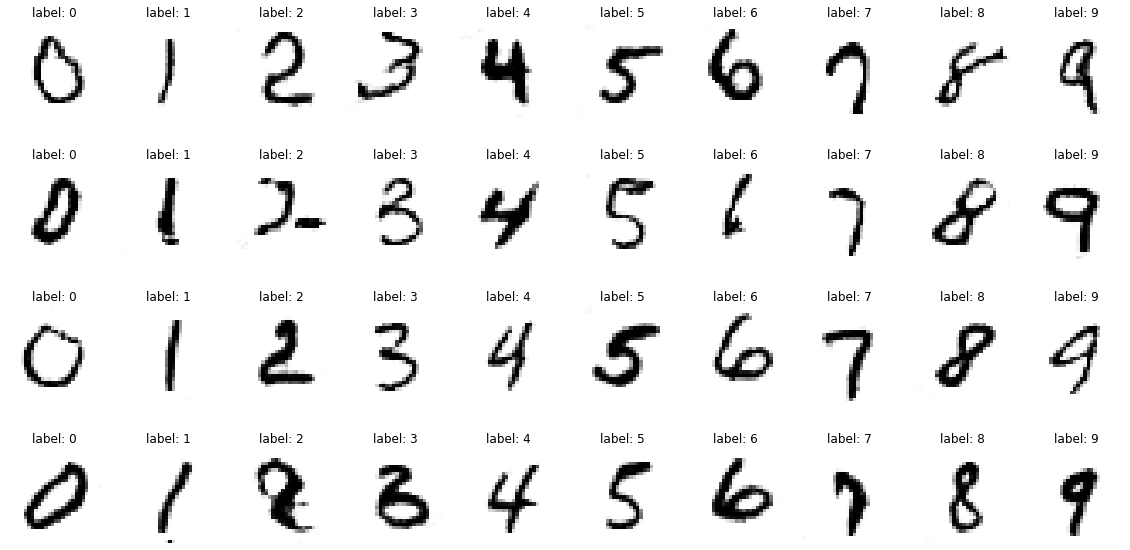

>81, 546/546, d_l=0.591, d_a=0.695 g=0.852
>82, 546/546, d_l=0.559, d_a=0.727 g=1.008
>83, 546/546, d_l=0.571, d_a=0.688 g=0.957
>84, 546/546, d_l=0.644, d_a=0.602 g=0.850
>85, 546/546, d_l=0.563, d_a=0.773 g=1.122
>86, 546/546, d_l=0.591, d_a=0.672 g=0.947
>87, 546/546, d_l=0.634, d_a=0.625 g=0.935
>88, 546/546, d_l=0.627, d_a=0.633 g=0.924
>89, 546/546, d_l=0.607, d_a=0.656 g=1.091
>90, 546/546, d_l=0.597, d_a=0.688 g=0.687
>91, 546/546, d_l=0.550, d_a=0.727 g=0.949
>92, 546/546, d_l=0.619, d_a=0.711 g=0.740
>93, 546/546, d_l=0.573, d_a=0.719 g=0.849
>94, 546/546, d_l=0.620, d_a=0.586 g=0.758
>95, 546/546, d_l=0.666, d_a=0.555 g=0.897
>96, 546/546, d_l=0.585, d_a=0.695 g=0.858
>97, 546/546, d_l=0.634, d_a=0.617 g=0.761
>98, 546/546, d_l=0.667, d_a=0.625 g=1.041
>99, 546/546, d_l=0.637, d_a=0.602 g=1.036
>100, 546/546, d_l=0.609, d_a=0.648 g=0.922


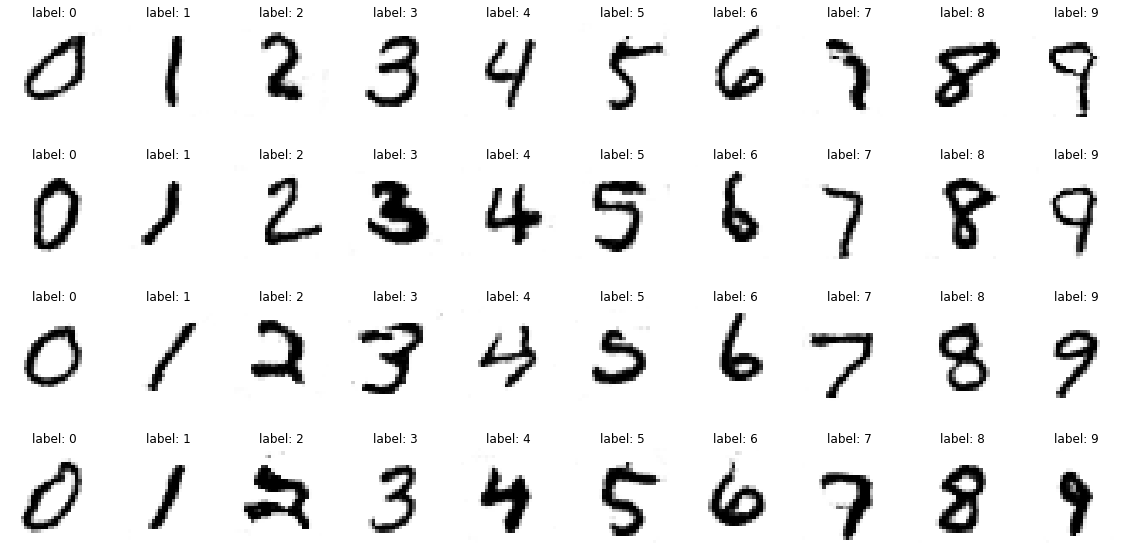

In [0]:
latent_dim = 10
discriminator = create_discriminator()
generator = create_generator(latent_dim)
gan_model = create_gan(generator, discriminator)
dataset = load_real_data(mnist)
train(generator, discriminator, gan_model, dataset, latent_dim)
# Save the generator model
gan_model.save('gan.h5')
generator.save('generator.h5')
discriminator.save('discriminator.h5')

>1, 546/546, d_l=0.649, d_a=0.711 g=0.767


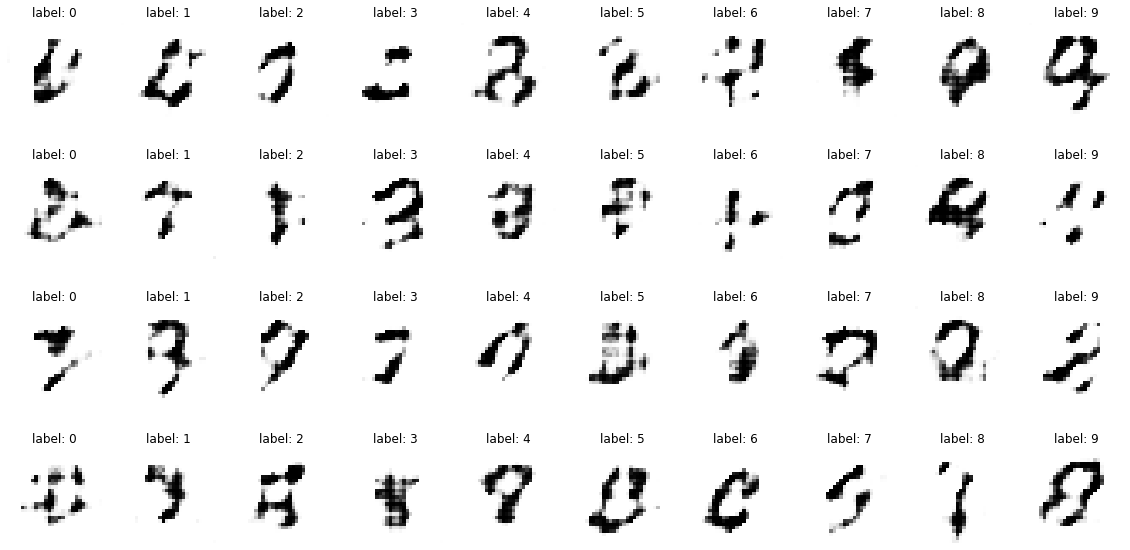

>2, 546/546, d_l=0.619, d_a=0.664 g=0.839


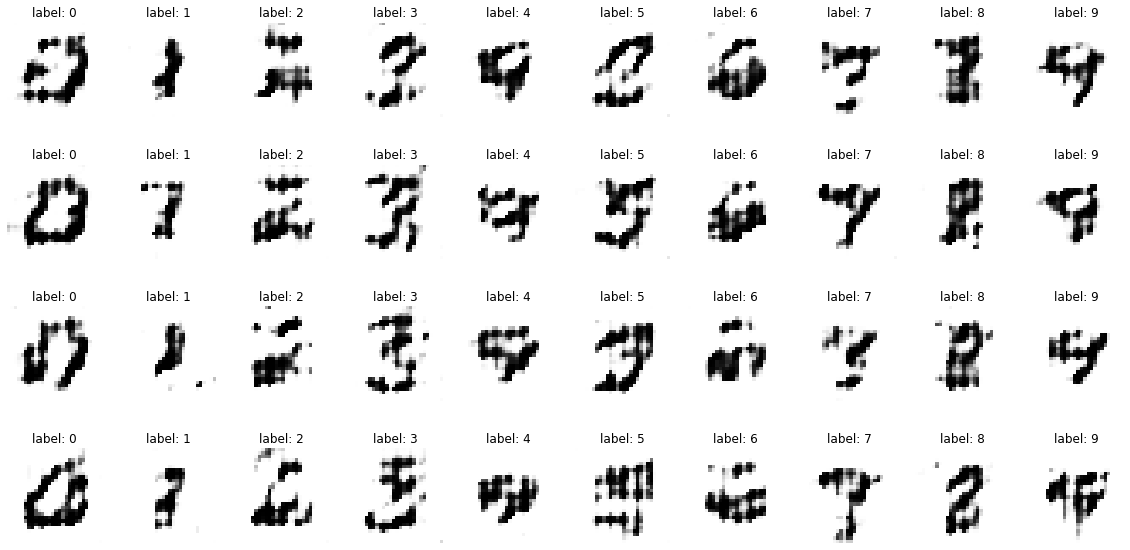

>3, 546/546, d_l=0.655, d_a=0.570 g=0.944
>4, 546/546, d_l=0.601, d_a=0.719 g=1.084
>5, 546/546, d_l=0.570, d_a=0.719 g=1.102
>6, 546/546, d_l=0.576, d_a=0.711 g=0.924
>7, 546/546, d_l=0.567, d_a=0.758 g=1.159
>8, 546/546, d_l=0.583, d_a=0.703 g=0.861
>9, 546/546, d_l=0.577, d_a=0.711 g=0.999
>10, 546/546, d_l=0.573, d_a=0.711 g=1.103
>11, 546/546, d_l=0.619, d_a=0.664 g=0.636
>12, 546/546, d_l=0.574, d_a=0.656 g=0.899
>13, 546/546, d_l=0.624, d_a=0.695 g=0.918
>14, 546/546, d_l=0.545, d_a=0.727 g=1.194
>15, 546/546, d_l=0.532, d_a=0.758 g=1.198
>16, 546/546, d_l=0.565, d_a=0.727 g=1.297
>17, 546/546, d_l=0.685, d_a=0.602 g=1.301
>18, 546/546, d_l=0.550, d_a=0.727 g=1.218
>19, 546/546, d_l=0.743, d_a=0.570 g=1.004
>20, 546/546, d_l=0.550, d_a=0.734 g=1.202


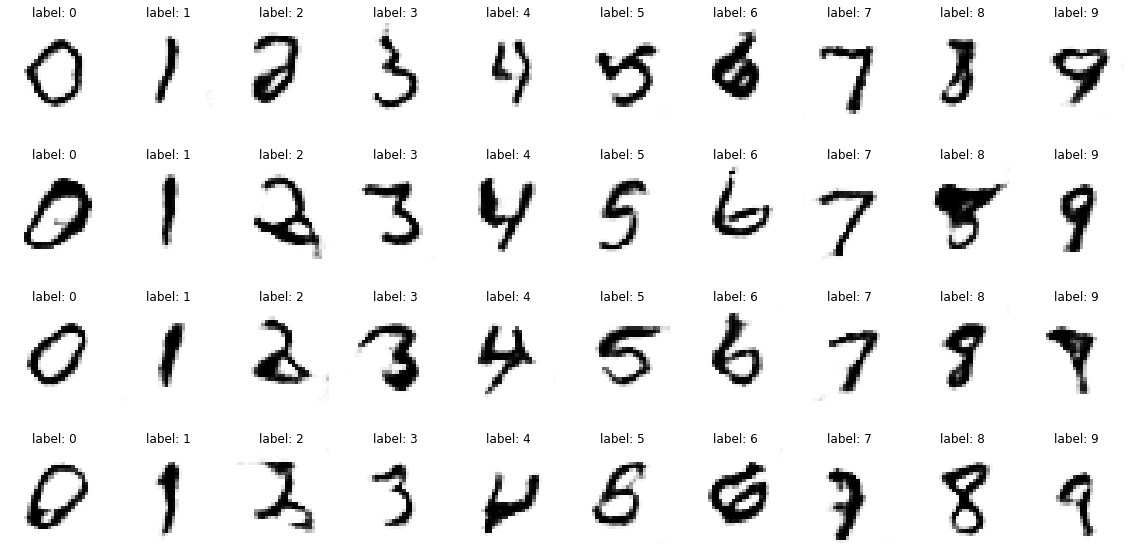

>21, 546/546, d_l=0.526, d_a=0.766 g=1.337
>22, 546/546, d_l=0.539, d_a=0.766 g=0.732
>23, 546/546, d_l=0.607, d_a=0.680 g=0.934
>24, 546/546, d_l=0.562, d_a=0.680 g=0.746
>25, 546/546, d_l=0.572, d_a=0.695 g=0.996
>26, 546/546, d_l=0.507, d_a=0.742 g=1.479
>27, 546/546, d_l=0.494, d_a=0.805 g=0.780
>28, 546/546, d_l=0.480, d_a=0.781 g=1.056
>29, 546/546, d_l=0.548, d_a=0.773 g=1.176
>30, 546/546, d_l=0.562, d_a=0.727 g=0.910
>31, 546/546, d_l=0.521, d_a=0.711 g=1.231
>32, 546/546, d_l=0.528, d_a=0.750 g=0.838
>33, 546/546, d_l=0.574, d_a=0.703 g=1.029
>34, 546/546, d_l=0.540, d_a=0.703 g=1.423
>35, 546/546, d_l=0.521, d_a=0.734 g=0.994
>36, 546/546, d_l=0.475, d_a=0.773 g=1.033
>37, 546/546, d_l=0.545, d_a=0.773 g=1.078
>38, 546/546, d_l=0.531, d_a=0.750 g=1.042
>39, 546/546, d_l=0.552, d_a=0.688 g=1.085
>40, 546/546, d_l=0.522, d_a=0.727 g=1.378


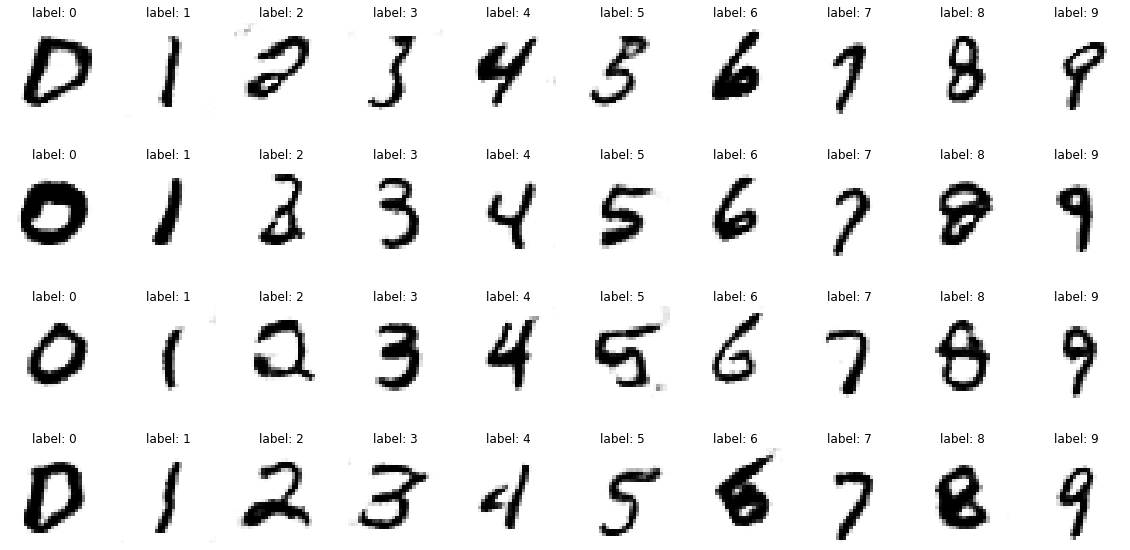

>41, 546/546, d_l=0.533, d_a=0.742 g=0.983
>42, 546/546, d_l=0.565, d_a=0.719 g=1.623
>43, 546/546, d_l=0.572, d_a=0.711 g=1.421
>44, 546/546, d_l=0.483, d_a=0.766 g=1.105
>45, 546/546, d_l=0.560, d_a=0.719 g=1.302
>46, 546/546, d_l=0.602, d_a=0.672 g=0.928
>47, 546/546, d_l=0.472, d_a=0.805 g=1.315
>48, 546/546, d_l=0.556, d_a=0.719 g=1.063
>49, 546/546, d_l=0.606, d_a=0.711 g=1.147
>50, 546/546, d_l=0.650, d_a=0.641 g=0.876
>51, 546/546, d_l=0.582, d_a=0.719 g=1.302
>52, 546/546, d_l=0.437, d_a=0.797 g=0.950
>53, 546/546, d_l=0.580, d_a=0.703 g=0.740
>54, 546/546, d_l=0.550, d_a=0.711 g=1.312
>55, 546/546, d_l=0.513, d_a=0.703 g=1.067
>56, 546/546, d_l=0.594, d_a=0.688 g=1.442
>57, 546/546, d_l=0.581, d_a=0.656 g=1.155
>58, 546/546, d_l=0.599, d_a=0.688 g=1.508
>59, 546/546, d_l=0.634, d_a=0.641 g=1.368
>60, 546/546, d_l=0.548, d_a=0.750 g=0.912


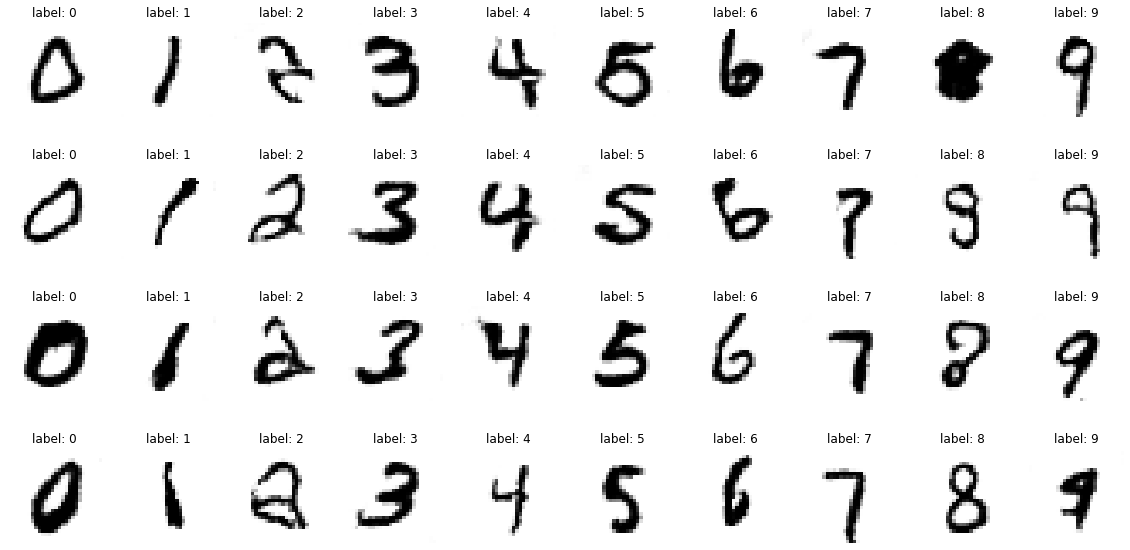

>61, 546/546, d_l=0.604, d_a=0.711 g=1.385
>62, 546/546, d_l=0.632, d_a=0.672 g=1.080
>63, 546/546, d_l=0.595, d_a=0.656 g=0.684
>64, 546/546, d_l=0.756, d_a=0.570 g=0.813
>65, 546/546, d_l=0.573, d_a=0.703 g=1.403
>66, 546/546, d_l=0.557, d_a=0.703 g=1.194
>67, 546/546, d_l=0.551, d_a=0.688 g=1.248
>68, 546/546, d_l=0.563, d_a=0.664 g=1.282
>69, 546/546, d_l=0.492, d_a=0.781 g=1.682
>70, 546/546, d_l=0.515, d_a=0.727 g=1.233
>71, 546/546, d_l=0.531, d_a=0.734 g=0.963
>72, 546/546, d_l=0.533, d_a=0.742 g=1.046
>73, 546/546, d_l=0.580, d_a=0.711 g=1.027
>74, 546/546, d_l=0.506, d_a=0.742 g=1.478
>75, 546/546, d_l=0.502, d_a=0.766 g=0.788
>76, 546/546, d_l=0.542, d_a=0.703 g=0.880
>77, 546/546, d_l=0.603, d_a=0.664 g=1.158
>78, 546/546, d_l=0.531, d_a=0.672 g=1.216
>79, 546/546, d_l=0.617, d_a=0.625 g=0.802
>80, 546/546, d_l=0.586, d_a=0.664 g=1.334


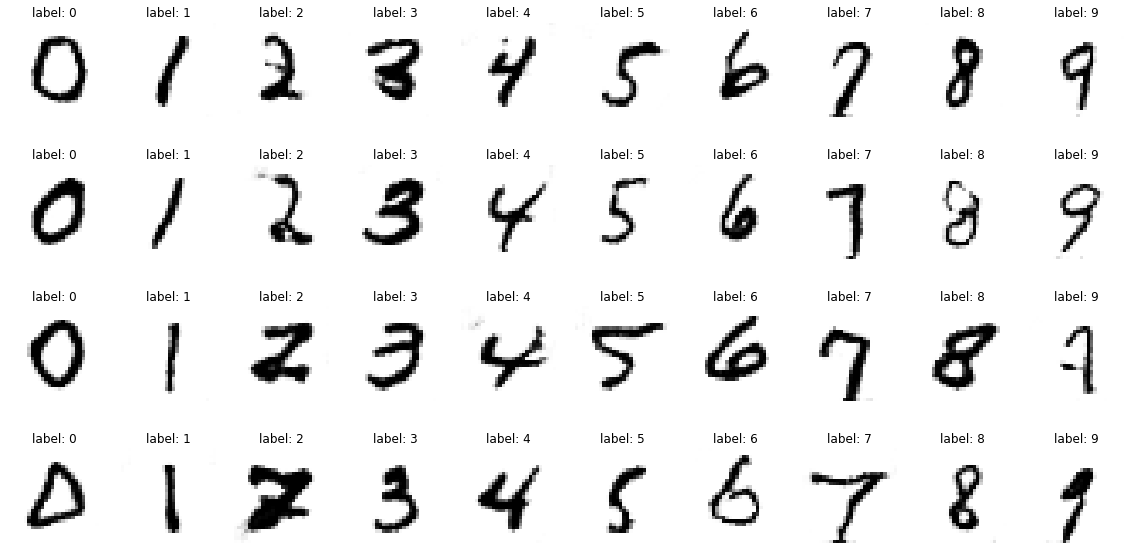

>81, 546/546, d_l=0.592, d_a=0.688 g=1.132
>82, 546/546, d_l=0.561, d_a=0.672 g=0.836
>83, 546/546, d_l=0.560, d_a=0.656 g=0.970
>84, 546/546, d_l=0.590, d_a=0.648 g=0.893
>85, 546/546, d_l=0.573, d_a=0.664 g=0.767
>86, 546/546, d_l=0.540, d_a=0.664 g=1.336
>87, 546/546, d_l=0.591, d_a=0.648 g=1.201
>88, 546/546, d_l=0.607, d_a=0.648 g=1.126
>89, 546/546, d_l=0.554, d_a=0.719 g=0.958
>90, 546/546, d_l=0.561, d_a=0.734 g=1.228
>91, 546/546, d_l=0.553, d_a=0.727 g=1.129
>92, 546/546, d_l=0.554, d_a=0.742 g=0.987
>93, 546/546, d_l=0.556, d_a=0.734 g=1.031
>94, 546/546, d_l=0.510, d_a=0.750 g=0.858
>95, 546/546, d_l=0.604, d_a=0.641 g=0.919
>96, 546/546, d_l=0.603, d_a=0.680 g=1.093
>97, 546/546, d_l=0.578, d_a=0.695 g=1.182
>98, 546/546, d_l=0.563, d_a=0.727 g=1.158
>99, 546/546, d_l=0.480, d_a=0.719 g=1.042
>100, 546/546, d_l=0.562, d_a=0.664 g=1.138


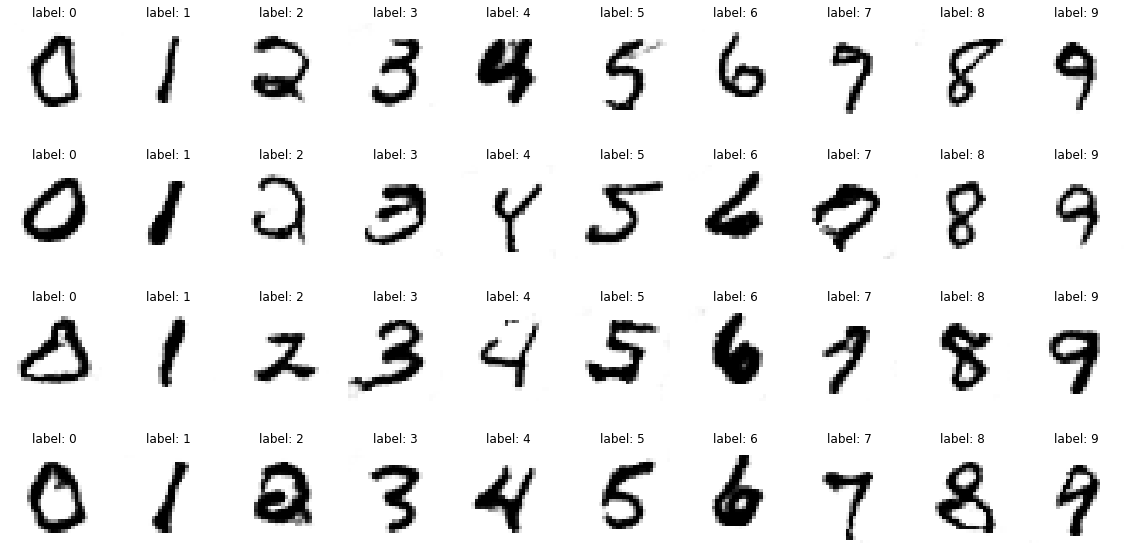

In [0]:
latent_dim = 1000
discriminator = create_discriminator()
generator = create_generator(latent_dim)
gan_model = create_gan(generator, discriminator)
dataset = load_real_data(mnist)
train(generator, discriminator, gan_model, dataset, latent_dim)
# Save the generator model
gan_model.save('gan.h5')
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [0]:
cp *.h5 "gdrive/My Drive/MLCourseFF"


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11493376/11490434 [==============================] - 0s 0us/step
>1, 546/546, d_l=0.000, d_a=1.000 g=9.174


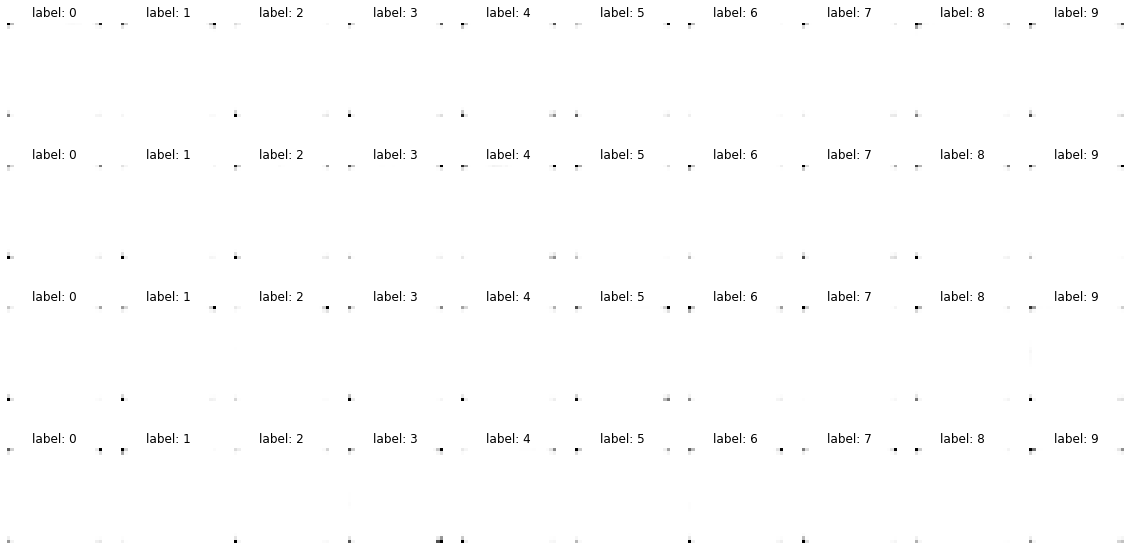

>2, 546/546, d_l=0.000, d_a=1.000 g=10.527


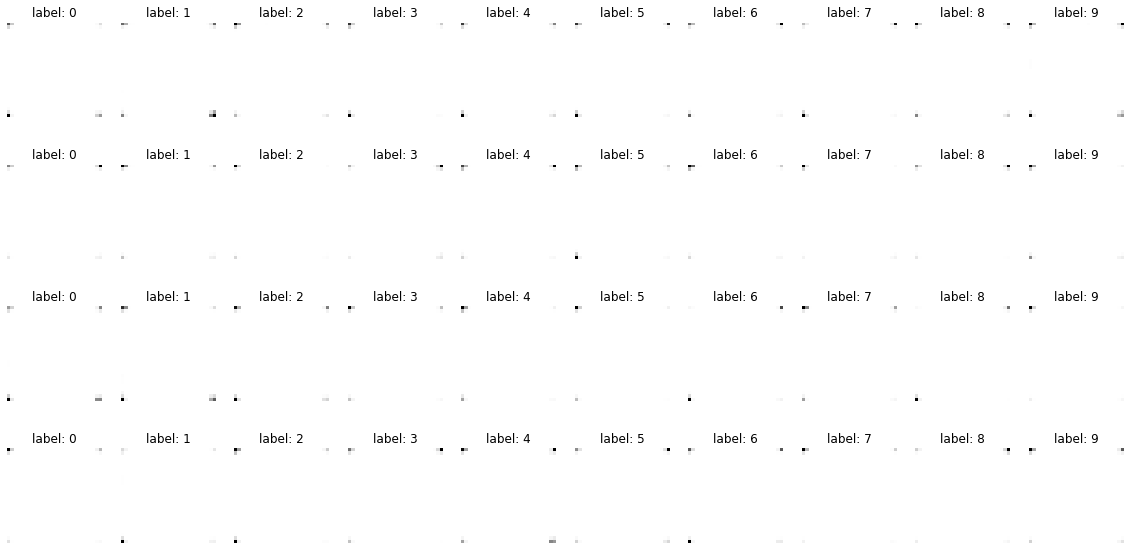

>3, 546/546, d_l=0.000, d_a=1.000 g=9.990
>4, 546/546, d_l=0.000, d_a=1.000 g=11.558
>5, 546/546, d_l=0.000, d_a=1.000 g=11.070
>6, 546/546, d_l=0.000, d_a=1.000 g=12.751
>7, 546/546, d_l=0.000, d_a=1.000 g=12.929
>8, 546/546, d_l=0.000, d_a=1.000 g=13.390
>9, 546/546, d_l=0.000, d_a=1.000 g=13.956
>10, 546/546, d_l=0.000, d_a=1.000 g=14.969
>11, 546/546, d_l=0.000, d_a=1.000 g=15.234
>12, 546/546, d_l=0.000, d_a=1.000 g=14.711
>13, 546/546, d_l=0.000, d_a=1.000 g=16.079
>14, 546/546, d_l=0.000, d_a=1.000 g=16.642
>15, 546/546, d_l=0.000, d_a=1.000 g=14.575
>16, 546/546, d_l=0.000, d_a=1.000 g=16.534
>17, 546/546, d_l=0.000, d_a=1.000 g=16.793
>18, 546/546, d_l=0.000, d_a=1.000 g=17.096
>19, 546/546, d_l=0.000, d_a=1.000 g=15.934
>20, 546/546, d_l=0.000, d_a=1.000 g=15.472


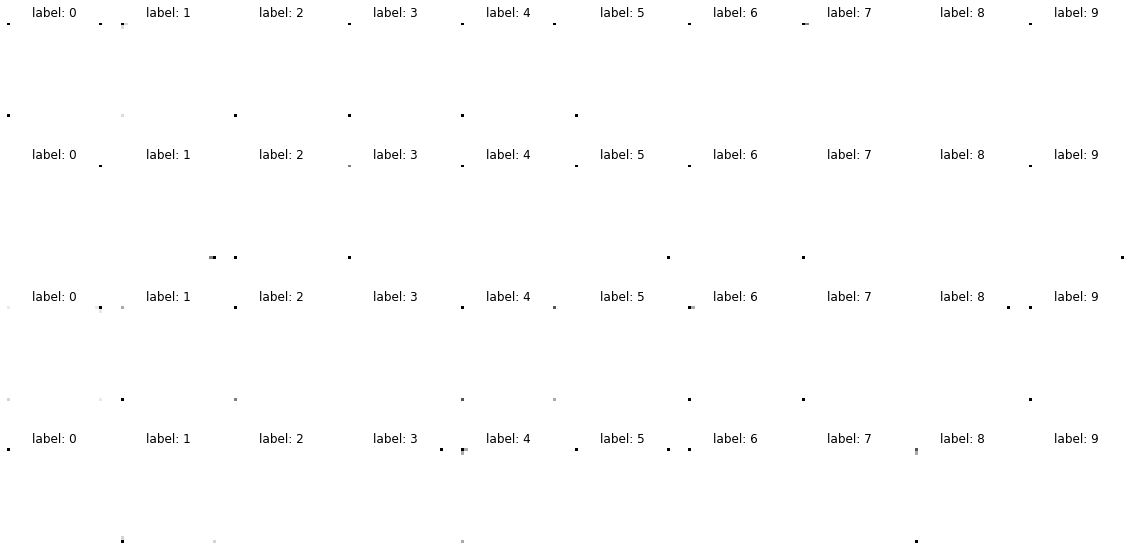

>21, 546/546, d_l=0.000, d_a=1.000 g=14.820
>22, 546/546, d_l=0.000, d_a=1.000 g=15.015
>23, 546/546, d_l=0.000, d_a=1.000 g=16.018
>24, 546/546, d_l=0.000, d_a=1.000 g=16.053
>25, 546/546, d_l=0.000, d_a=1.000 g=16.302
>26, 546/546, d_l=0.000, d_a=1.000 g=16.971
>27, 546/546, d_l=0.000, d_a=1.000 g=16.679
>28, 546/546, d_l=0.000, d_a=1.000 g=17.471
>29, 546/546, d_l=0.000, d_a=1.000 g=17.947
>30, 546/546, d_l=0.000, d_a=1.000 g=17.678
>31, 546/546, d_l=0.000, d_a=1.000 g=18.316
>32, 546/546, d_l=0.000, d_a=1.000 g=18.373
>33, 546/546, d_l=0.000, d_a=1.000 g=18.728
>34, 546/546, d_l=0.000, d_a=1.000 g=19.200
>35, 546/546, d_l=0.000, d_a=1.000 g=19.256
>36, 546/546, d_l=0.000, d_a=1.000 g=19.360
>37, 546/546, d_l=0.000, d_a=1.000 g=19.756
>38, 546/546, d_l=0.000, d_a=1.000 g=17.735
>39, 546/546, d_l=0.000, d_a=1.000 g=20.253
>40, 546/546, d_l=0.000, d_a=1.000 g=20.254


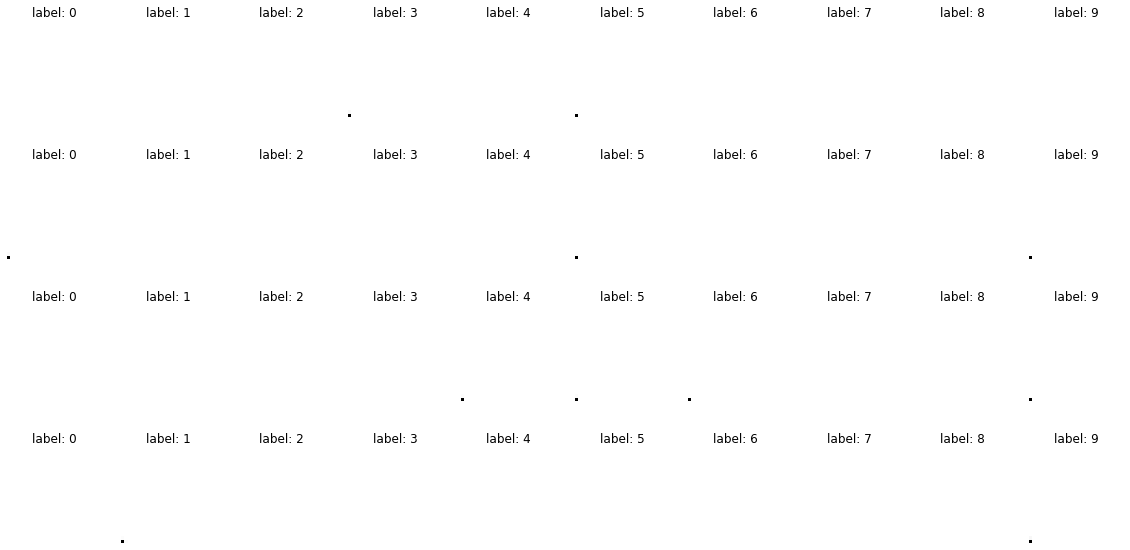

>41, 546/546, d_l=0.000, d_a=1.000 g=21.127
>42, 546/546, d_l=0.000, d_a=1.000 g=21.637
>43, 546/546, d_l=0.000, d_a=1.000 g=22.041
>44, 546/546, d_l=0.000, d_a=1.000 g=22.095
>45, 546/546, d_l=0.000, d_a=1.000 g=22.387
>46, 546/546, d_l=0.000, d_a=1.000 g=22.792
>47, 546/546, d_l=0.000, d_a=1.000 g=23.325
>48, 546/546, d_l=0.000, d_a=1.000 g=22.667
>49, 546/546, d_l=0.000, d_a=1.000 g=23.105
>50, 546/546, d_l=0.000, d_a=1.000 g=22.777
>51, 546/546, d_l=0.000, d_a=1.000 g=23.231
>52, 546/546, d_l=0.000, d_a=1.000 g=23.427
>53, 546/546, d_l=0.000, d_a=1.000 g=23.670
>54, 546/546, d_l=0.000, d_a=1.000 g=23.201
>55, 546/546, d_l=0.000, d_a=1.000 g=23.610
>56, 546/546, d_l=0.000, d_a=1.000 g=24.019
>57, 546/546, d_l=0.000, d_a=1.000 g=24.215
>58, 546/546, d_l=0.000, d_a=1.000 g=24.162
>59, 546/546, d_l=0.000, d_a=1.000 g=23.805
>60, 546/546, d_l=0.000, d_a=1.000 g=24.165


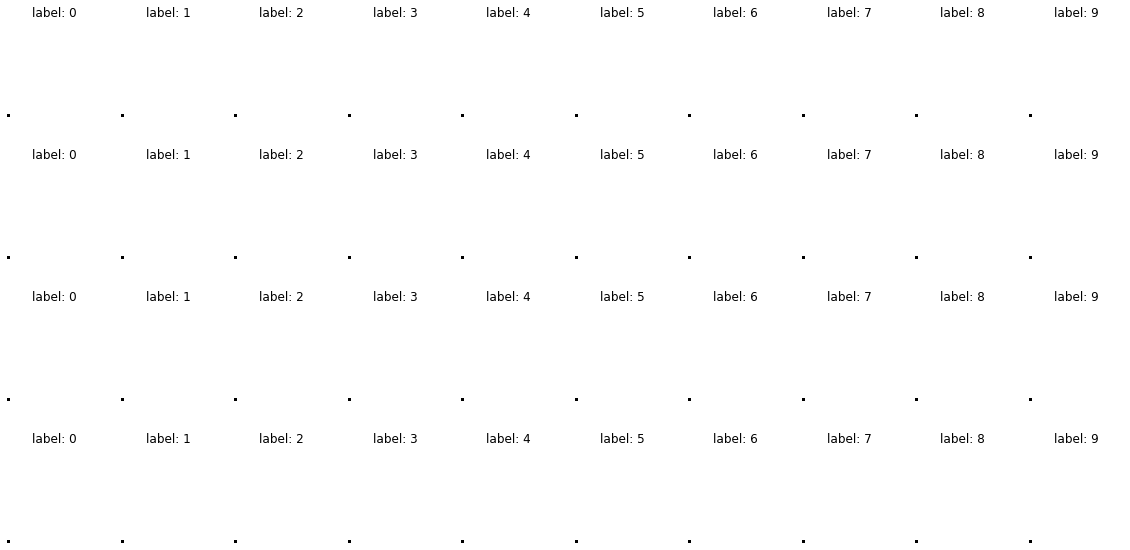

>61, 546/546, d_l=0.000, d_a=1.000 g=24.847
>62, 546/546, d_l=0.000, d_a=1.000 g=24.632
>63, 546/546, d_l=0.000, d_a=1.000 g=24.894
>64, 546/546, d_l=0.000, d_a=1.000 g=24.396
>65, 546/546, d_l=0.000, d_a=1.000 g=24.638
>66, 546/546, d_l=0.000, d_a=1.000 g=24.734
>67, 546/546, d_l=0.000, d_a=1.000 g=24.625
>68, 546/546, d_l=0.000, d_a=1.000 g=24.882
>69, 546/546, d_l=0.000, d_a=1.000 g=25.255
>70, 546/546, d_l=0.000, d_a=1.000 g=25.110
>71, 546/546, d_l=0.000, d_a=1.000 g=25.129
>72, 546/546, d_l=0.000, d_a=1.000 g=24.084
>73, 546/546, d_l=0.000, d_a=1.000 g=24.706
>74, 546/546, d_l=0.000, d_a=1.000 g=25.160
>75, 546/546, d_l=0.000, d_a=1.000 g=25.044
>76, 546/546, d_l=0.000, d_a=1.000 g=25.117
>77, 546/546, d_l=0.000, d_a=1.000 g=25.058
>78, 546/546, d_l=0.000, d_a=1.000 g=25.517
>79, 546/546, d_l=0.000, d_a=1.000 g=25.670
>80, 546/546, d_l=0.000, d_a=1.000 g=25.680


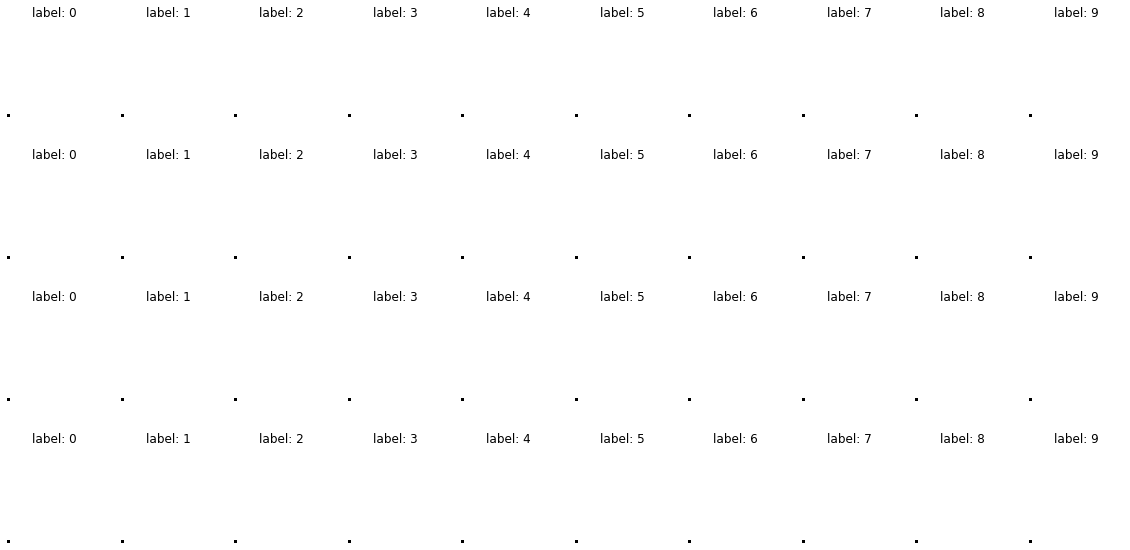

>81, 546/546, d_l=0.000, d_a=1.000 g=25.405
>82, 546/546, d_l=0.000, d_a=1.000 g=25.495
>83, 546/546, d_l=0.000, d_a=1.000 g=25.066
>84, 546/546, d_l=0.000, d_a=1.000 g=25.581
>85, 546/546, d_l=0.000, d_a=1.000 g=25.894
>86, 546/546, d_l=0.000, d_a=1.000 g=25.828
>87, 546/546, d_l=0.000, d_a=1.000 g=25.927
>88, 546/546, d_l=0.000, d_a=1.000 g=25.435
>89, 546/546, d_l=0.000, d_a=1.000 g=25.735
>90, 546/546, d_l=0.000, d_a=1.000 g=25.879
>91, 546/546, d_l=0.000, d_a=1.000 g=25.888
>92, 546/546, d_l=0.000, d_a=1.000 g=25.760
>93, 546/546, d_l=0.000, d_a=1.000 g=26.134
>94, 546/546, d_l=0.000, d_a=1.000 g=25.744
>95, 546/546, d_l=0.000, d_a=1.000 g=25.679
>96, 546/546, d_l=0.000, d_a=1.000 g=25.866
>97, 546/546, d_l=0.000, d_a=1.000 g=26.022
>98, 546/546, d_l=0.000, d_a=1.000 g=26.164
>99, 546/546, d_l=0.000, d_a=1.000 g=26.234
>100, 546/546, d_l=0.000, d_a=1.000 g=26.178


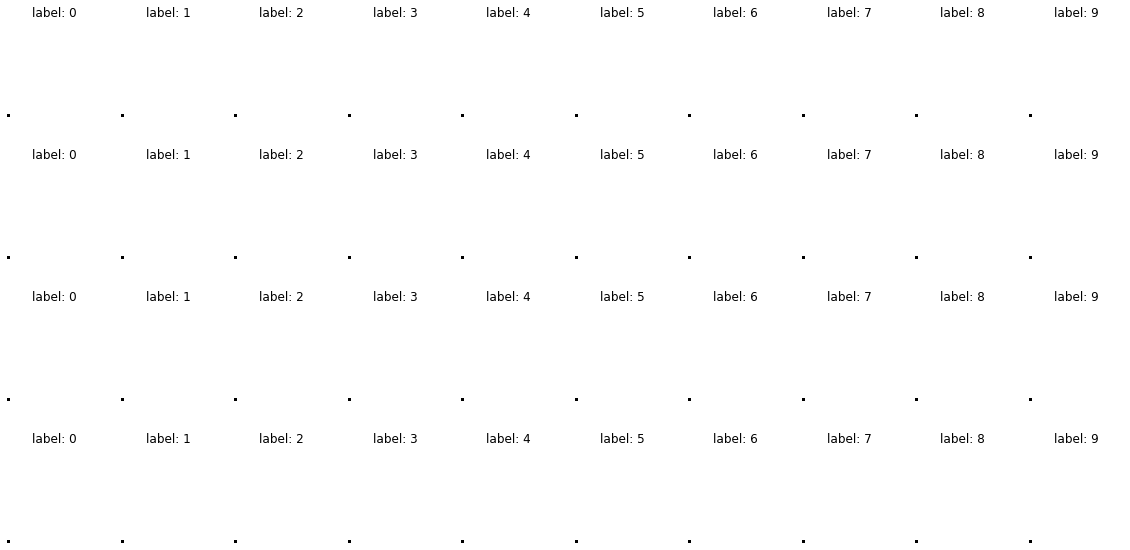

In [0]:
latent_dim = 10000
discriminator = create_discriminator()
generator = create_generator(latent_dim)
gan_model = create_gan(generator, discriminator)
dataset = load_real_data(mnist)
train(generator, discriminator, gan_model, dataset, latent_dim)
# Save the generator model
gan_model.save('gan.h5')
generator.save('generator.h5')
discriminator.save('discriminator.h5')